# 時系列データ

## 準備

### インポート

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# warningsを非表示（任意）
warnings.filterwarnings('ignore')

# numpyは小数第3位まで表示
np.set_printoptions(precision=3, suppress=True)

# 乱数を設定
np.random.seed(10)

## VARLiNGAM

### テストデータ（VAR）

In [2]:
# データの読み込み：公式リポジトリ(cdt15/lingam)より引用
# https://github.com/cdt15/lingam/blob/master/examples/data/sample_data_var_lingam.csv
X = pd.read_csv('data/sample_data_var_lingam.csv')

$$
\begin{align*}
\boldsymbol{x}(t)&=B_0\boldsymbol{x}(t)+B_1\boldsymbol{x}(t-1)+\boldsymbol{e}(t)\\
\end{align*}
$$

$$
\begin{align*}
\begin{array}{l}
x_0(t)=\\
x_1(t)=\\
x_2(t)=\\
x_3(t)=\\
x_4(t)=
\end{array}
\underbrace{
\begin{array}{rrr}
-0.12x_1(t)\\
\\
-0.41x_0(t) & +0.01x_1(t) & -0.02x_3(t)\\
0.04x_0(t) & -0.22x_1(t)\\
0.15x_0(t) & -0.03x_2(t)
\end{array}
}_{B_0\boldsymbol{x}(t)}\:\:
\underbrace{
\begin{array}{rrrr}
-0.32x_0(t-1) & +0.12x_2(t-1) & +0.32x_3(t-1)\\
-0.35x_1(t-1) & -0.10x_2(t-1) & -0.46x_3(t-1) & +0.4x_4(t-1)\\
+0.37x_2(t-1) & +0.46x_4(t-1)\\
-0.38x_0(t-1) & -0.10x_1(t-1) & -0.24x_2(t-1) & -0.13x_4(t-1)\\
\\
\end{array}
}_{B_1\boldsymbol{x}(t-1)}\:\:
\begin{array}{l}
+e_0(t)\\
+e_1(t)\\
+e_2(t)\\
+e_3(t)\\
+e_4(t)
\end{array}
\end{align*}
$$

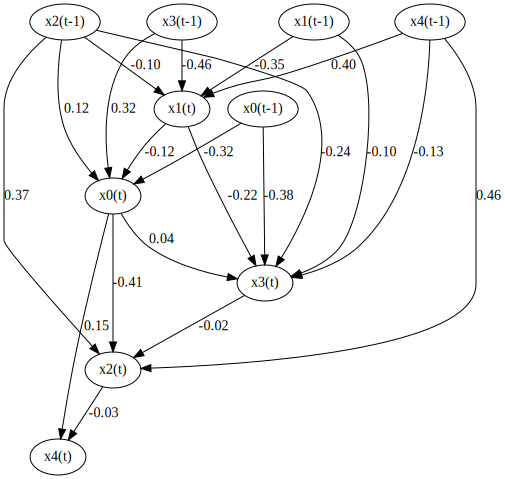

In [3]:
# 線形方程式の係数（因果効果）を行列で表現
# 時間遅れ=0（同時刻）の因果効果
B0 = np.array([[ 0.00,-0.12, 0.00, 0.00, 0.00],
               [ 0.00, 0.00, 0.00, 0.00, 0.00],
               [-0.41, 0.01, 0.00,-0.02, 0.00],
               [ 0.04,-0.22, 0.00, 0.00, 0.00],
               [ 0.15, 0.00,-0.03, 0.00, 0.00]])

# 時間遅れ=1の因果効果
B1 = np.array([[-0.32, 0.00, 0.12, 0.32, 0.00],
               [ 0.00,-0.35,-0.10,-0.46, 0.40],
               [ 0.00, 0.00, 0.37, 0.00, 0.46],
               [-0.38,-0.10,-0.24, 0.00,-0.13],
               [ 0.00, 0.00, 0.00, 0.00, 0.00]])

# グラフの作成
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)']
dot = lingam.utils.make_dot(np.hstack([B0,B1]), ignore_shape=True, labels=labels)

# pdf形式で保存
dot.render('VARLiNGAM_dag')

# png形式で保存
dot.format = 'png'
dot.render('VARLiNGAM_dag')

# グラフの描写
dot

### 因果探索

In [4]:
# VARLiNGAM オブジェクト
model = lingam.VARLiNGAM()

# 学習
model.fit(X)

In [5]:
# （推定）因果的順序の表示
model.causal_order_

[1, 0, 3, 2, 4]

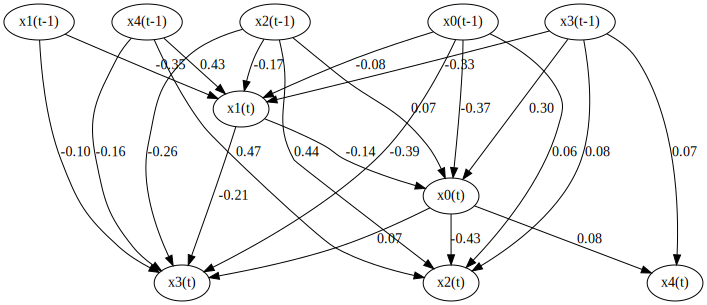

In [6]:
# グラフの作成
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)']
dot = lingam.utils.make_dot(np.hstack(model.adjacency_matrices_), ignore_shape=True, lower_limit=0.05, labels=labels)

# pdf形式で保存
dot.render('VARLiNGAM_pred_dag')

# png形式で保存
dot.format = 'png'
dot.render('VARLiNGAM_pred_dag')

# グラフの描写
dot

### 残差間の独立性検定

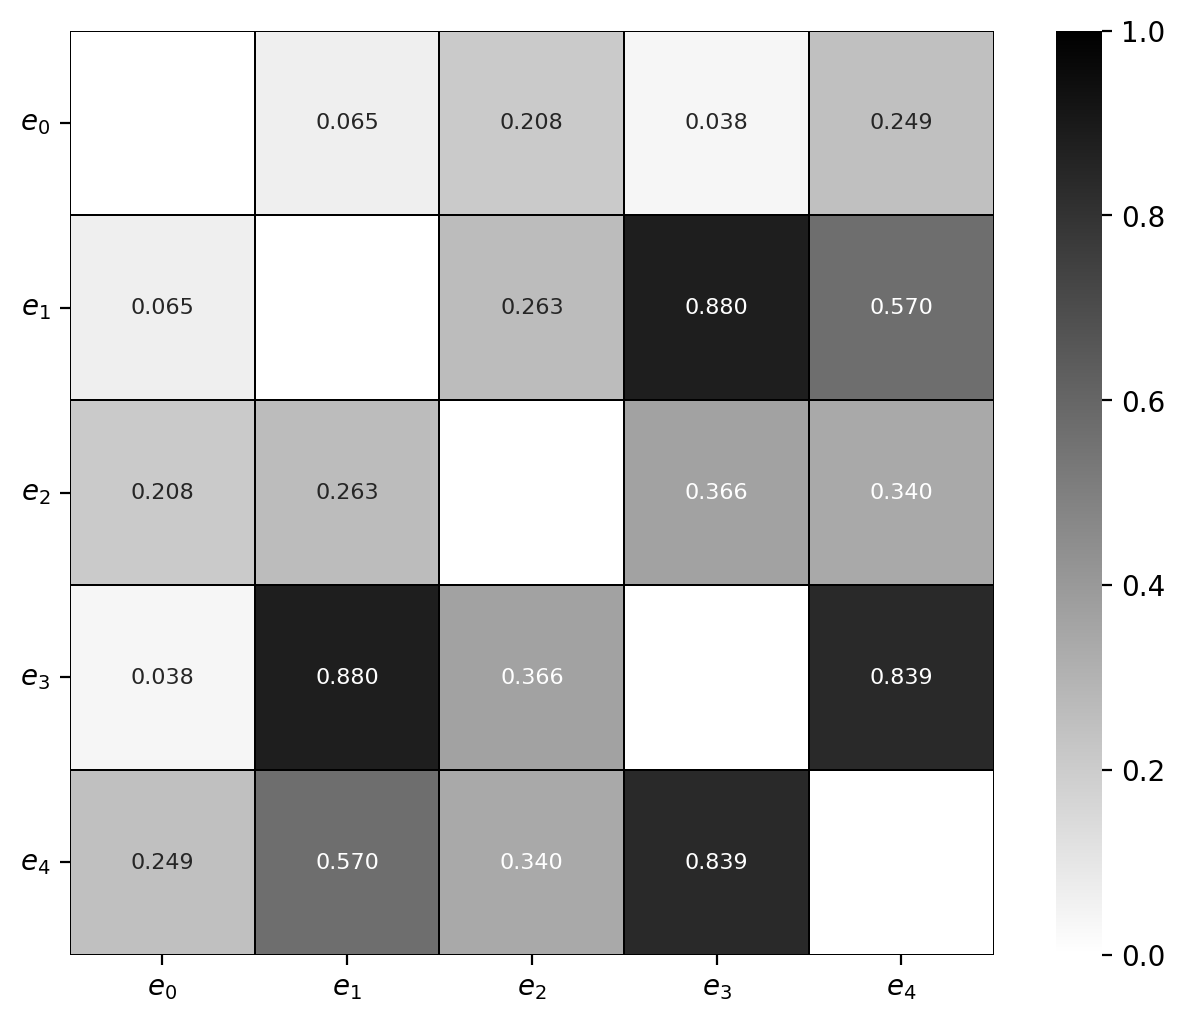

In [7]:
# 変数の合計数を計算
P = X.shape[1]

# 独立性検定のp値を計算
p_values = model.get_error_independence_p_values()

# 対角成分は考慮すべきでないため取り除く
p_values_nan = p_values + np.diag(np.ones(P)*np.nan)

# ヒートマップとして可視化
plt.figure(figsize=[8,6], dpi=200)
sns.heatmap(p_values_nan, square=True, cmap='binary', linewidths=.05, linecolor='k', vmin=0.0, vmax=1.0, annot=True, fmt="1.3f", annot_kws={'fontsize':8})
ticks_label = [fr'$e_{{{i}}}$' for i in range(P)]
plt.xticks(np.arange(P)+0.5, ticks_label, rotation=0, fontsize=10)
plt.yticks(np.arange(P)+0.5, ticks_label, rotation=0, fontsize=10)
plt.savefig('Pvalues_VARLiNGAM.png')

### ブートストラップ法

In [8]:
# VARLiNGAM のオブジェクト
model = lingam.VARLiNGAM()

# ブートストラップ法（サンプリング数100）で学習
result = model.bootstrap(X, n_sampling=100)

### 因果方向

In [9]:
# ブートストラップ法の結果に基づき因果の矢印を確度の高い順で集計
# n_directions: 集計する因果の矢印の数（ランキング順）
# min_causal_effect: 集計する係数（因果効果）の最小値
# split_by_causal_effect_sign: 係数（因果効果）の符号を区別するかどうか
cdc = result.get_causal_direction_counts(n_directions=10, min_causal_effect=0.3, split_by_causal_effect_sign=True)

In [10]:
# 集計結果の表示
# 第2引数（=100）はブートストラップ法のサンプリング数を入力
# 第3引数（=labels）はラベルを入力
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)']
lingam.utils.print_causal_directions(cdc, 100, labels=labels)

x0(t) <--- x0(t-1) (b<0) (100.0%)
x1(t) <--- x1(t-1) (b<0) (100.0%)
x1(t) <--- x3(t-1) (b<0) (100.0%)
x1(t) <--- x4(t-1) (b>0) (100.0%)
x2(t) <--- x2(t-1) (b>0) (100.0%)
x2(t) <--- x4(t-1) (b>0) (100.0%)
x3(t) <--- x0(t-1) (b<0) (100.0%)
x2(t) <--- x0(t) (b<0) (99.0%)
x0(t) <--- x3(t-1) (b>0) (25.0%)


### 有向非巡回グラフ

In [11]:
# ブートストラップ法の結果に基づき因果構造を確度の高い順で集計
# n_dags: 集計する因果構造の数（ランキング順）
# min_causal_effect: 考慮する係数（因果効果）の最小値
# split_by_causal_effect_sign: 係数（因果効果）の符号を区別するかどうか
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.3, split_by_causal_effect_sign=True)

In [12]:
# 集計結果の表示
# 第2引数（=100）はブートストラップサンプル数を入力
# 第3引数（=labels）はラベルを入力
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)']
lingam.utils.print_dagc(dagc, 100, labels=labels)

DAG[0]: 75.0%
	x0(t) <--- x0(t-1) (b<0)
	x1(t) <--- x1(t-1) (b<0)
	x1(t) <--- x3(t-1) (b<0)
	x1(t) <--- x4(t-1) (b>0)
	x2(t) <--- x0(t) (b<0)
	x2(t) <--- x2(t-1) (b>0)
	x2(t) <--- x4(t-1) (b>0)
	x3(t) <--- x0(t-1) (b<0)
DAG[1]: 24.0%
	x0(t) <--- x0(t-1) (b<0)
	x0(t) <--- x3(t-1) (b>0)
	x1(t) <--- x1(t-1) (b<0)
	x1(t) <--- x3(t-1) (b<0)
	x1(t) <--- x4(t-1) (b>0)
	x2(t) <--- x0(t) (b<0)
	x2(t) <--- x2(t-1) (b>0)
	x2(t) <--- x4(t-1) (b>0)
	x3(t) <--- x0(t-1) (b<0)
DAG[2]: 1.0%
	x0(t) <--- x0(t-1) (b<0)
	x0(t) <--- x3(t-1) (b>0)
	x1(t) <--- x1(t-1) (b<0)
	x1(t) <--- x3(t-1) (b<0)
	x1(t) <--- x4(t-1) (b>0)
	x2(t) <--- x2(t-1) (b>0)
	x2(t) <--- x4(t-1) (b>0)
	x3(t) <--- x0(t-1) (b<0)


### 出現確率

In [13]:
# ブートストラップ法の結果に基づき各因果の矢印の出現確率を集計
# min_causal_effect: 考慮する係数（因果効果）の最小値
prob = result.get_probabilities(min_causal_effect=0.1)

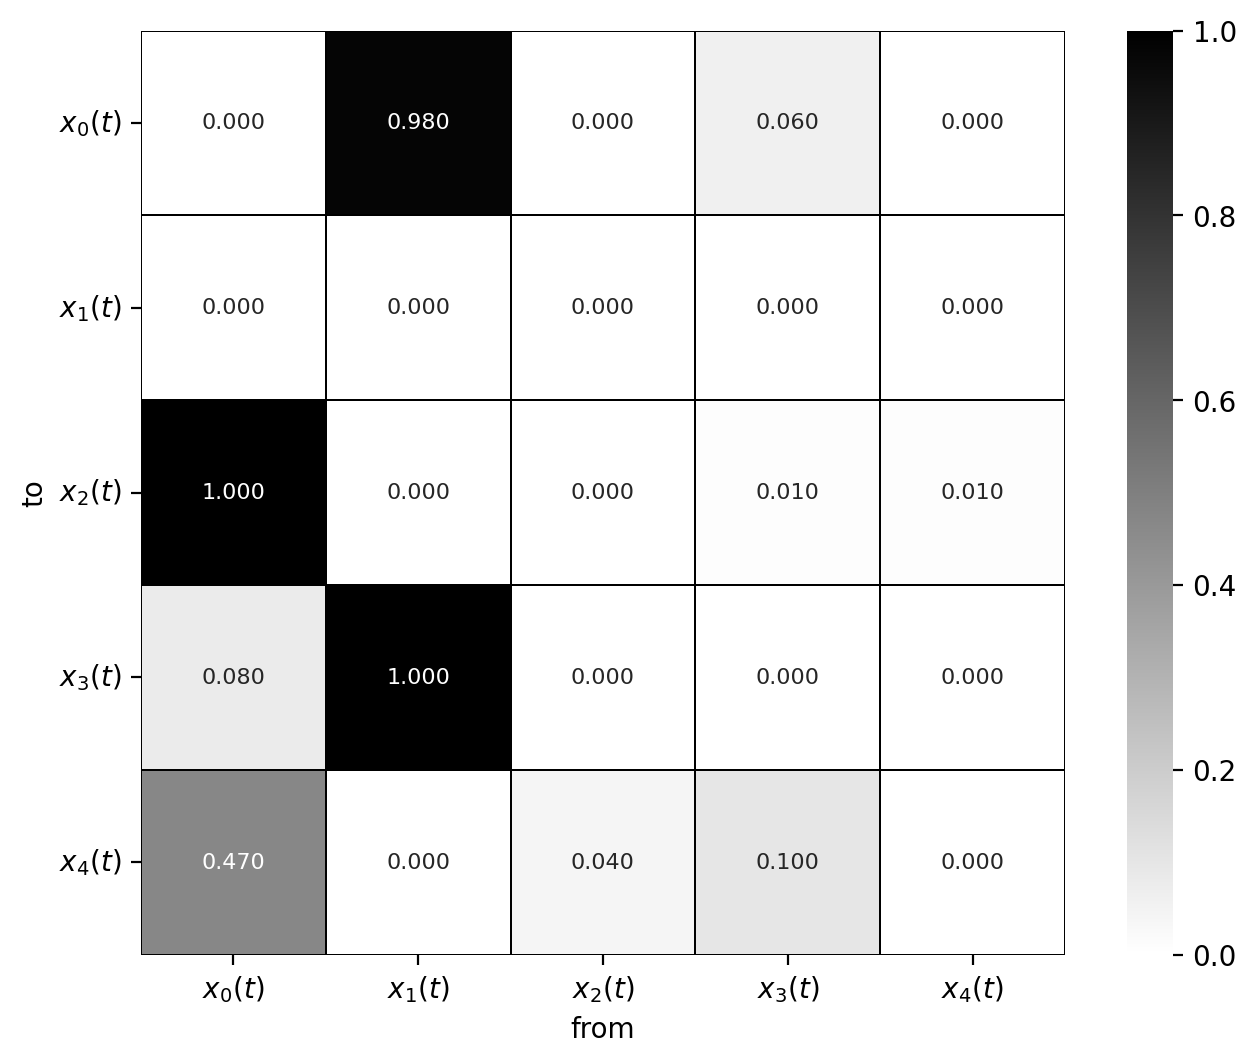

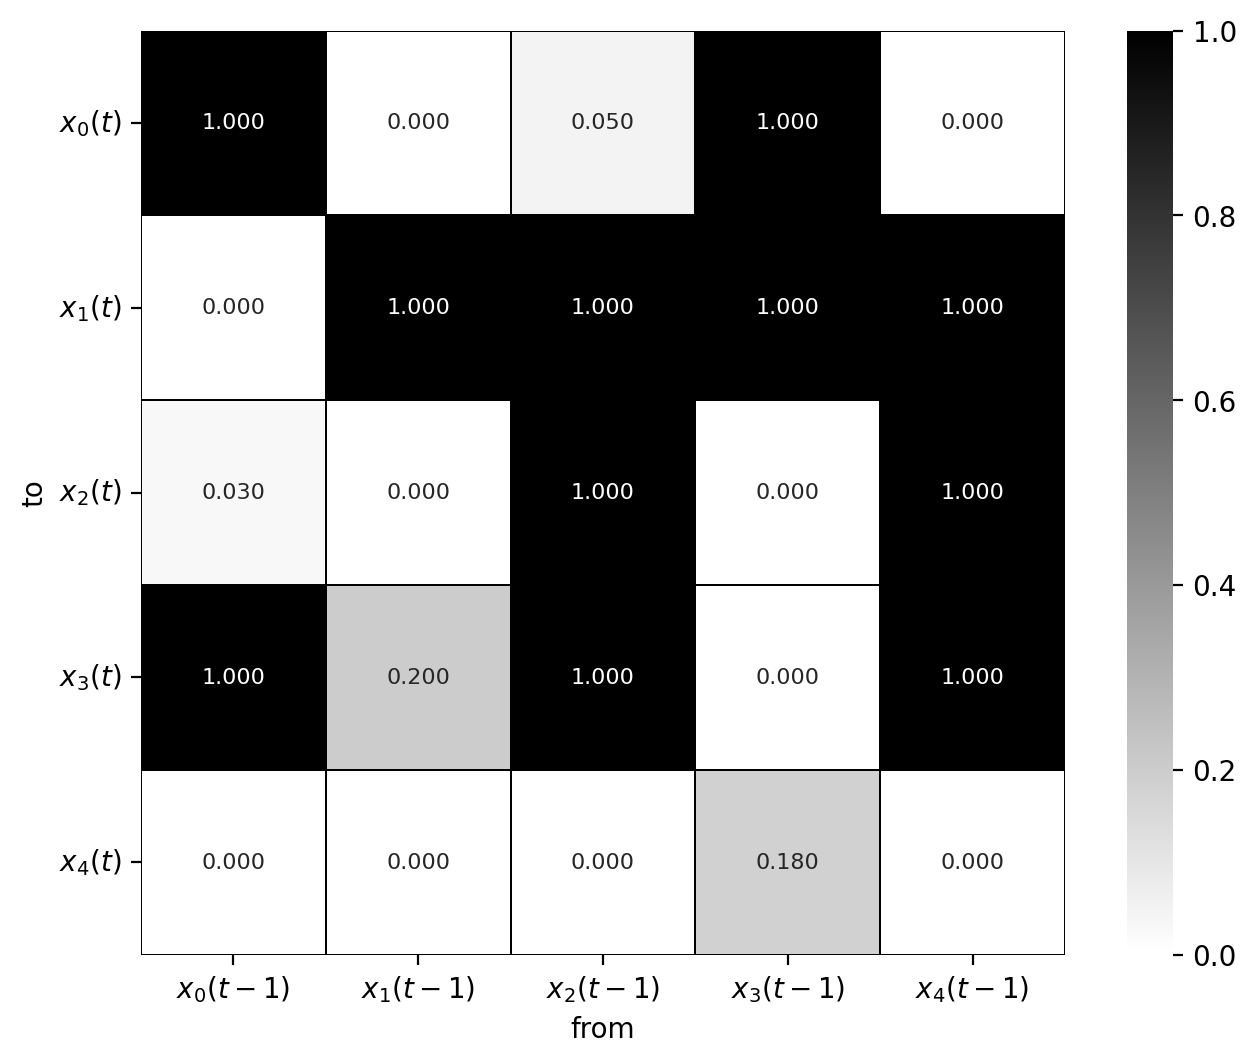

In [14]:
# ヒートマップとしてB0の集計結果を可視化
plt.figure(figsize=[8,6], dpi=200)
sns.heatmap(prob[0], square=True, cmap='binary', linewidths=.05, linecolor='k', vmin=0.0, vmax=1.0, annot=True, fmt="1.3f", annot_kws={'fontsize':8})
xticks_label = [fr'$x_{{{i}}}(t)$' for i in range(P)]
yticks_label = [fr'$x_{{{i}}}(t)$' for i in range(P)]
plt.xticks(np.arange(P)+0.5, xticks_label, rotation=0, fontsize=10)
plt.yticks(np.arange(P)+0.5, yticks_label, rotation=0, fontsize=10)
plt.xlabel('from')
plt.ylabel('to')
plt.savefig('VARLiNGAM_pred_B0.png')
plt.show()

# ヒートマップとしてB1の集計結果を可視化
plt.figure(figsize=[8,6], dpi=200)
sns.heatmap(prob[1], square=True, cmap='binary', linewidths=.05, linecolor='k', vmin=0.0, vmax=1.0, annot=True, fmt="1.3f", annot_kws={'fontsize':8})
xticks_label = [fr'$x_{{{i}}}(t-1)$' for i in range(P)]
yticks_label = [fr'$x_{{{i}}}(t)$' for i in range(P)]
plt.xticks(np.arange(P)+0.5, xticks_label, rotation=0, fontsize=10)
plt.yticks(np.arange(P)+0.5, yticks_label, rotation=0, fontsize=10)
plt.xlabel('from')
plt.ylabel('to')
plt.savefig('VARLiNGAM_pred_B1.png')
plt.show()

### （総合）因果効果

In [15]:
# ブートストラップ法の結果に基づき（総合）因果効果を計算
# min_causal_effect: 考慮する係数（因果効果）の最小値
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

# DataFrameに結果をまとめる
df = pd.DataFrame(causal_effects)
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)']
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])

In [16]:
# （総合）因果効果の大きい順にトップ5を表示
print(df.sort_values('effect', ascending=False).head())

       from     to    effect  probability
5   x4(t-1)  x2(t)  0.460745         1.00
8   x4(t-1)  x1(t)  0.411727         1.00
9   x2(t-1)  x2(t)  0.322000         1.00
11  x3(t-1)  x0(t)  0.281191         1.00
14    x0(t)  x4(t)  0.109973         0.97


In [17]:
# 存在確率の小さい順にトップ5を表示
print(df.sort_values('probability', ascending=True).head())

       from     to    effect  probability
38    x4(t)  x0(t)  0.083126         0.01
37  x2(t-1)  x4(t)  0.054696         0.01
36  x4(t-1)  x4(t) -0.038050         0.02
35  x0(t-1)  x1(t)  0.065408         0.03
34  x0(t-1)  x4(t) -0.071190         0.04


In [18]:
# x2(t)に向かう（総合）因果効果を表示
print(df[df['to']=='x2(t)'])

       from     to    effect  probability
5   x4(t-1)  x2(t)  0.460745         1.00
6     x1(t)  x2(t)  0.088616         1.00
7     x0(t)  x2(t) -0.418157         1.00
9   x2(t-1)  x2(t)  0.322000         1.00
16  x0(t-1)  x2(t)  0.089005         0.90
19  x3(t-1)  x2(t) -0.082017         0.74
22  x1(t-1)  x2(t) -0.042153         0.61
26    x4(t)  x2(t) -0.056386         0.25
27    x3(t)  x2(t) -0.035070         0.25


### 経路の存在確率と（総合）因果効果

In [19]:
# ブートストラップ法の結果に基づき経路の存在確率と（総合）因果効果を計算
from_index = labels.index('x0(t-1)') # 原因となる変数（x0(t-1)）のインデックス
to_index = labels.index('x3(t)') # 結果となる変数（x3）のインデックス

# 指定したインデックスの（総合）因果効果を取得
target_effects = pd.DataFrame(result.get_paths(from_index, to_index))

# pathをインデックス表記からラベルに変更
target_effects['path'] = target_effects['path'].apply(lambda x: ' -> '.join([labels[i] for i in x]))

# 存在確率の大きい順にトップ5を表示
print(target_effects.head())

                                   path    effect  probability
0             x0(t-1) -> x1(t) -> x3(t)  0.017190          1.0
1           x0(t-1) -> x2(t-1) -> x3(t)  0.105267          1.0
2                      x0(t-1) -> x3(t) -0.410895          1.0
3  x0(t-1) -> x2(t-1) -> x1(t) -> x3(t) -0.014144          1.0
4  x0(t-1) -> x4(t-1) -> x1(t) -> x3(t) -0.009427          0.8


## VARMALiNGAM

### テストデータ（VARMA）

In [20]:
# データの読み込み：公式リポジトリ(cdt15/lingam)より引用
# https://github.com/cdt15/lingam/blob/master/examples/data/sample_data_varma_lingam.csv
X = pd.read_csv('data/sample_data_varma_lingam.csv')

$$
\begin{align*}
\boldsymbol{x}(t)=\Psi_0\boldsymbol{x}(t)+\Psi_1\boldsymbol{x}(t-1)+e(t)+\Theta_1\boldsymbol{e}(t-1)
\end{align*}
$$

$$
\begin{align*}
\begin{array}{l}
x_0(t)=\\
x_1(t)=\\
x_2(t)=\\
x_3(t)=\\
x_4(t)=
\end{array}
\underbrace{
\begin{array}{rrr}
-0.25x_2(t)\\
-0.38x_0(t) & +0.14x_2(t)\\
\\
0.44x_0(t) & -0.20x_1(t) & -0.09x_2(t)\\
0.07x_0(t) & -0.06x_1(t) & +0.07x_3(t)
\end{array}
}_{\Psi_0\boldsymbol{x}(t)}\:\:
\underbrace{
\begin{array}{rrrr}
-0.04x_0(t-1) & -0.29x_1(t-1) & -0.26x_2(t-1) & +0.14x_3(t-1) & +0.47x_4(t-1)\\
-0.42x_0(t-1) & +0.20x_1(t-1) & +0.10x_2(t-1) & +0.24x_3(t-1) & +0.25x_4(t-1)\\
-0.25x_0(t-1) & +0.18x_1(t-1) & -0.06x_2(t-1) & +0.15x_3(t-1) & +0.18x_4(t-1)\\
+0.22x_0(t-1) & +0.39x_1(t-1) & +0.08x_2(t-1) & +0.12x_3(t-1) & -0.37x_4(t-1)\\
-0.43x_0(t-1) & +0.09x_1(t-1) & -0.23x_2(t-1) & +0.16x_3(t-1) & +0.25x_4(t-1)
\end{array}
}_{\Psi_1\boldsymbol{x}(t-1)}\:\:
\begin{array}{l}
+e_0(t)\\
+e_1(t)\\
+e_2(t)\\
+e_3(t)\\
+e_4(t)
\end{array}\:\:
\underbrace{
\begin{array}{rrrr}
+0.15x_0(t-1) & -0.02x_1(t-1) & -0.30x_2(t-1) & +0.20x_3(t-1) & +0.21x_4(t-1)\\
+0.32x_0(t-1) & +0.12x_1(t-1) & -0.11x_2(t-1) & +0.03x_3(t-1) & +0.42x_4(t-1)\\
-0.07x_0(t-1) & -0.50x_1(t-1) & +0.03x_2(t-1) & -0.27x_3(t-1) & -0.21x_4(t-1)\\
-0.17x_0(t-1) & +0.35x_1(t-1) & +0.25x_2(t-1) & +0.24x_3(t-1) & -0.25x_4(t-1)\\
+0.09x_0(t-1) & +0.40x_1(t-1) & +0.41x_2(t-1) & +0.24x_3(t-1) & -0.31x_4(t-1)
\end{array}
}_{\Theta_1\boldsymbol{e}(t-1)}
\end{align*}
$$

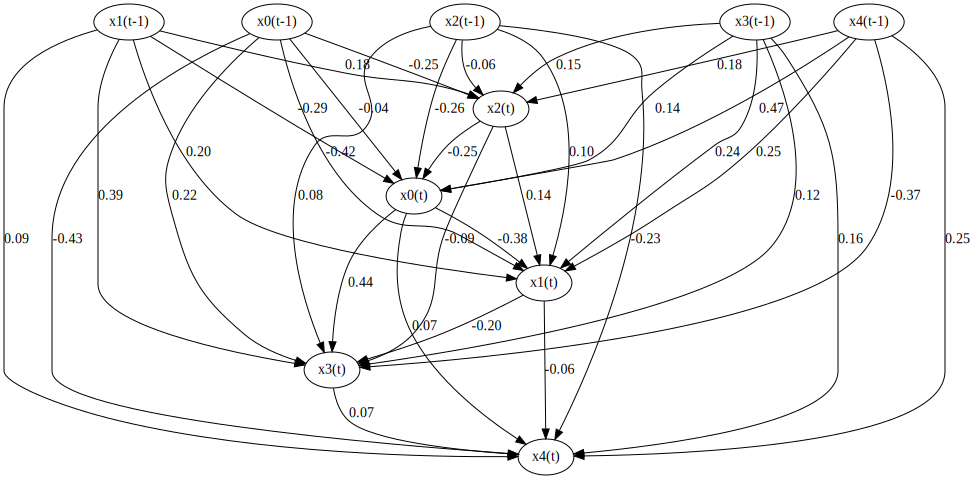

In [21]:
# 線形方程式の係数（因果効果）を行列で表現
# 時間遅れ=0（同時刻）の因果効果
psi0 = np.array([[ 0.  ,  0.  , -0.25,  0.  ,  0.  ],
                 [-0.38,  0.  ,  0.14,  0.  ,  0.  ],
                 [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
                 [ 0.44, -0.2 , -0.09,  0.  ,  0.  ],
                 [ 0.07, -0.06,  0.  ,  0.07,  0.  ]])

# 時間遅れ=1の因果効果
psi1 = np.array([[-0.04, -0.29, -0.26,  0.14,  0.47],
                 [-0.42,  0.2 ,  0.1 ,  0.24,  0.25],
                 [-0.25,  0.18, -0.06,  0.15,  0.18],
                 [ 0.22,  0.39,  0.08,  0.12, -0.37],
                 [-0.43,  0.09, -0.23,  0.16,  0.25]])

# 時間遅れ=1の移動平均項
theta1 = np.array([[ 0.15, -0.02, -0.3 , -0.2 ,  0.21],
                   [ 0.32,  0.12, -0.11,  0.03,  0.42],
                   [-0.07, -0.5 ,  0.03, -0.27, -0.21],
                   [-0.17,  0.35,  0.25,  0.24, -0.25],
                   [ 0.09,  0.4 ,  0.41,  0.24, -0.31]])

# グラフの作成
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)']
dot = lingam.utils.make_dot(np.hstack([psi0,psi1]), ignore_shape=True, labels=labels)

# pdf形式で保存
dot.render('VARMALiNGAM_dag')

# png形式で保存
dot.format = 'png'
dot.render('VARMALiNGAM_dag')

# グラフの描写
dot

### 因果探索

In [22]:
# VARMALiNGAM オブジェクト
model = lingam.VARMALiNGAM()

# 学習
model.fit(X)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           45     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11037D+01    |proj g|=  2.69983D+00

At iterate    5    f=  7.71249D+00    |proj g|=  1.52173D-01

At iterate   10    f=  7.61286D+00    |proj g|=  5.93834D-02

At iterate   15    f=  7.59535D+00    |proj g|=  1.58892D-02

At iterate   20    f=  7.59325D+00    |proj g|=  8.17552D-03

At iterate   25    f=  7.59296D+00    |proj g|=  2.27807D-03

At iterate   30    f=  7.59291D+00    |proj g|=  7.23560D-04

At iterate   35    f=  7.59291D+00    |proj g|=  5.72601D-04

At iterate   40    f=  7.59290D+00    |proj g|=  3.72372D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  7.34816D+00    |proj g|=  1.96444D-03

At iterate   10    f=  7.34815D+00    |proj g|=  9.72220D-04

At iterate   15    f=  7.34814D+00    |proj g|=  2.42125D-04

At iterate   20    f=  7.34814D+00    |proj g|=  8.41505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   45     20     23      1     0     0   8.415D-05   7.348D+00
  F =   7.3481442631187397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           70     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.12444D+00    |proj g|=  1.93123D-01

At iterate   10    f=  7.07521D+00    |proj g|=  6.26311D-02

At iterate   15    f=  7.05747D+00    |proj g|=  5.66412D-02

At iterate   20    f=  7.04955D+00    |proj g|=  3.89587D-02

At iterate   25    f=  7.04448D+00    |proj g|=  2.73402D-02

At iterate   30    f=  7.04059D+00    |proj g|=  2.40829D-02

At iterate   35    f=  7.03802D+00    |proj g|=  1.55023D-02

At iterate   40    f=  7.03651D+00    |proj g|=  4.37341D-02

At iterate   45    f=  7.03582D+00    |proj g|=  2.03768D-02

At iterate   50    f=  7.03537D+00    |proj g|=  1.29226D-02

At iterate   55    f=  7.03508D+00    |proj g|=  1.01621D-02

At iterate   60    f=  7.03495D+00    |proj g|=  4.10723D-03

At iterate   65    f=  7.03479D+00    |proj g|=  3.64774D-03

At iterate   70    f=  7.03472D+00    |proj g|=  4.60441D-03

At iterate   75    f=  7.03466D+00    |proj g|=  2.87121D-03

At iterate   80    f=  7.03463D+00    |proj g|=  5.88077D-03

At iter

In [23]:
# （推定）因果的順序の表示
model.causal_order_

[2, 0, 1, 3, 4]

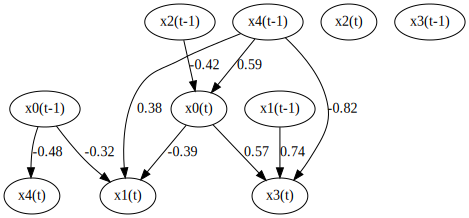

In [24]:
# グラフの作成
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)']
dot = lingam.utils.make_dot(np.hstack(model.adjacency_matrices_[0]), ignore_shape=True, lower_limit=0.3, labels=labels)

# pdf形式で保存
dot.render('VARMALiNGAM_pred_dag')

# png形式で保存
dot.format = 'png'
dot.render('VARMALiNGAM_pred_dag')

# グラフの描写
dot

### 残差間の独立性検定

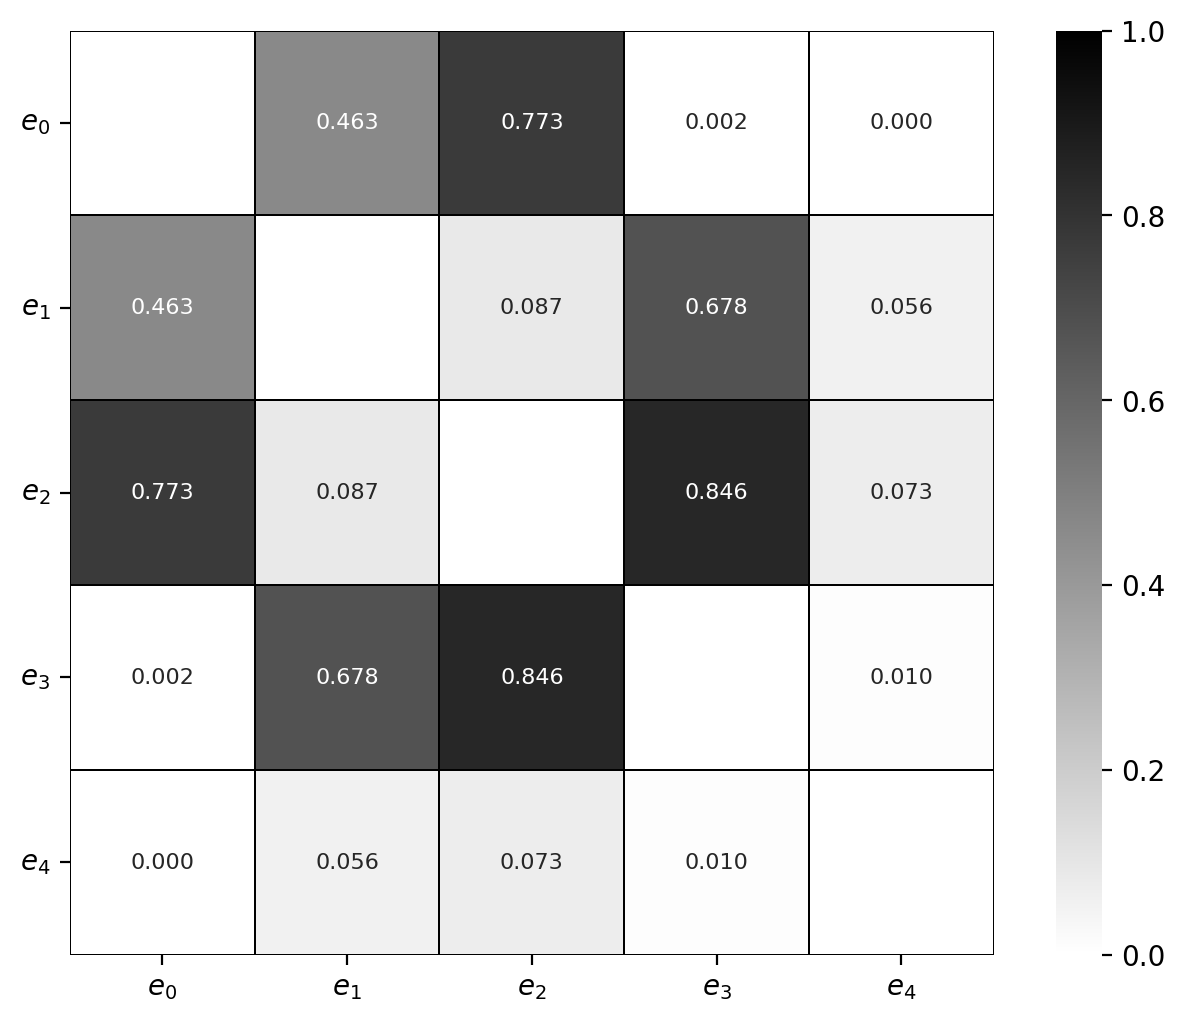

In [25]:
# 変数の合計数を計算
P = X.shape[1]

# 独立性検定のp値を計算
p_values = model.get_error_independence_p_values()

# 対角成分は考慮すべきでないため取り除く
p_values_nan = p_values + np.diag(np.ones(P)*np.nan)

# ヒートマップとして可視化
plt.figure(figsize=[8,6], dpi=200)
sns.heatmap(p_values_nan, square=True, cmap='binary', linewidths=.05, linecolor='k', vmin=0.0, vmax=1.0, annot=True, fmt="1.3f", annot_kws={'fontsize':8})
ticks_label = [fr'$e_{{{i}}}$' for i in range(P)]
plt.xticks(np.arange(P)+0.5, ticks_label, rotation=0, fontsize=10)
plt.yticks(np.arange(P)+0.5, ticks_label, rotation=0, fontsize=10)
plt.savefig('Pvalues_VARMALiNGAM.png')